# HW7
## MSDS-7337
## Author: Taylor Bonar
---
Cluster the reviews that you collected in homework 5, by doing the following:
1. In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.

### Scraping top 250 on IMdb first 25 reviews by prolific reviewers

In [1]:
from platform import python_version
import bs4
import pandas as pd
import requests
import re
import nltk

print(f"""Python Version: {python_version()}
NLTK v.{nltk.__version__}
BeautifulSoup v.{bs4.__version__}
Pandas v.{pd.__version__}
Requests v.{requests.__version__}
Re v.{re.__version__}""")

Python Version: 3.8.12
NLTK v.3.6.5
BeautifulSoup v.4.9.3
Pandas v.1.1.3
Requests v.2.26.0
Re v.2.2.1


In [4]:
import json
import os

movies_df = pd.read_csv("top_250_movies.csv").drop(["Unnamed: 0"], axis=1)

def get_review_headliner(title_url_link):
    """Retrieves review headliner text for top 25 reviews displayed for a given movie title"""
    url = f"https://www.imdb.com{title_url_link}reviews"  # review link pattern for imdb
    response = requests.get(url)  # hit the original page
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    #list comphrehension for imdb movie reviews for specific title
    #remove leading whitespace and ending \n because IMDB formats it that way
    return [headline.get_text().lstrip().strip('\n') for headline in soup.find_all('a', class_='title',href=True)] 

reviews_dict = {}
if os.path.isfile("./reviews.json"):
    with open("reviews.json", "r") as input_file:
        reviews_dict = json.load(input_file)
else:
    for movie in movies_df.itertuples():
        reviews_dict[movie.movie_title] = get_review_headliner(movie.link)

print(len(reviews_dict.keys()))

# Saving reviews so I don't need to rescrape
if not os.path.isfile("./reviews.json"):
    with open("reviews.json", "w") as outfile:
        json.dump(reviews_dict, outfile)

250


### Clustering

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(sum(list(reviews_dict.values()), []))

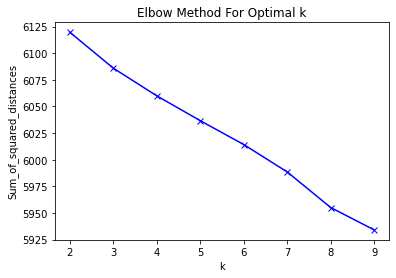

In [14]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering via k-means on 3 and 8 as that's where the elbow method curves.

In [20]:
true_k = 3
model_k3 = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model_k3.fit(X)

# List clusters
labels_k3 = model_k3.labels_
review_clusters_3 = pd.DataFrame(list(zip(reviews_dict.keys(), labels_k3)),columns=['title','cluster'])
print(review_clusters_3.sort_values(by=['cluster']))

                        title  cluster
0    The Shawshank Redemption        0
146            Shutter Island        0
149             Jurassic Park        0
150          Kill Bill: Vol 1        0
151              Finding Nemo        0
..                        ...      ...
222              The Exorcist        2
3      The Godfather: Part II        2
104          Double Indemnity        2
111           LA Confidential        2
82          Good Will Hunting        2

[250 rows x 2 columns]


In [21]:
true_k = 8
model_k8 = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model_k8.fit(X)

# list clusers
labels_k8 = model_k8.labels_
review_clusters_8 = pd.DataFrame(list(zip(reviews_dict.keys(), labels_k8)),columns=['title','cluster'])
print(review_clusters_8.sort_values(by=['cluster']))

                            title  cluster
163          Howl's Moving Castle        0
46   Once Upon a Time in the West        0
51                    City Lights        0
52                        Memento        0
156            Gone with the Wind        0
..                            ...      ...
130                    The Father        7
132                    Green Book        7
136               Pan's Labyrinth        7
120               Bicycle Thieves        7
249                The Handmaiden        7

[250 rows x 2 columns]



2. Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 


In [25]:
from wordcloud import WordCloud

Cluster: 0
Titles
                          The Shawshank Redemption
                                     The Godfather
                                   The Dark Knight
                                      12 Angry Men
                                  Schindler's List
     The Lord of the Rings: The Return of the King
                                      Pulp Fiction
 The Lord of the Rings: The Fellowship of the Ring
                    The Good, the Bad and the Ugly
                                        Fight Club
                                         Inception
             The Lord of the Rings: The Two Towers
    Star Wars: Episode V - The Empire Strikes Back
                                        The Matrix
                                        Goodfellas
                   One Flew Over the Cuckoo's Nest
                                             Se7en
                                     Seven Samurai
                             It's a Wonderful Life
             

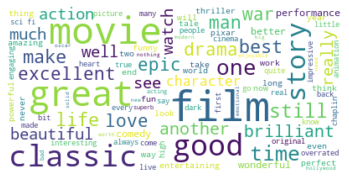

Cluster: 1
Titles
                                      Forrest Gump
                                     Spirited Away
                                          Parasite
                                         Gladiator
                                      The Prestige
                                             Alien
 Dr Strangelove or: How I Learned to Stop Worry...
                                              Coco
                              Inglourious Basterds
                               Requiem for a Dream
        Star Wars: Episode VI - Return of the Jedi
                                      High and Low
                                                 M
                                          The Hunt
                                          Scarface
                                       Taxi Driver
                Indiana Jones and the Last Crusade
                                     Batman Begins
                                          Downfall
             

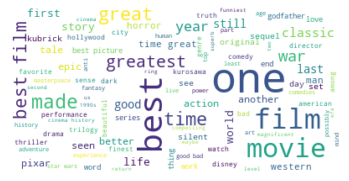

Cluster: 2
Titles
                       The Godfather: Part II
                            Life Is Beautiful
                             The Intouchables
                       Grave of the Fireflies
                            Good Will Hunting
                             Double Indemnity
                              LA Confidential
                                        Fargo
 Harry Potter and the Deathly Hallows: Part 2
                    In the Name of the Father
                                 The Exorcist


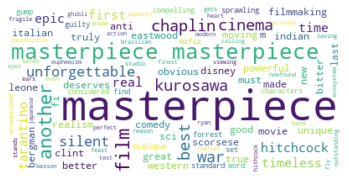

In [30]:
result_k3 = pd.DataFrame({'cluster':labels_k3,'review': sum(list(reviews_dict.values()), [])})

for k in range(0,3):
   s = result_k3[result_k3.cluster == k]
   text = s['review'].str.cat(sep=' ').lower()
   text = ' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   
   print('Titles')
   titles = review_clusters_3[review_clusters_3.cluster == k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

Cluster: 0
Titles
                                         Inception
    Star Wars: Episode V - The Empire Strikes Back
                                    The Green Mile
                                      Interstellar
                      Once Upon a Time in the West
                                       Rear Window
                                       City Lights
                                           Memento
                               The Lives of Others
                                       The Shining
                             The Dark Knight Rises
                                         Toy Story
                                          3 Idiots
                                          Hamilton
                            For a Few Dollars More
                           The Wolf of Wall Street
                                Gone with the Wind
                              Howl's Moving Castle
      Harry Potter and the Deathly Hallows: Part 2
             

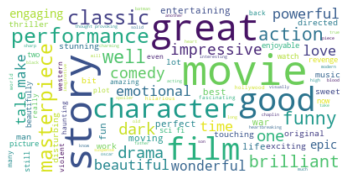

Cluster: 1
Titles
 The Lord of the Rings: The Return of the King
                                 The Lion King
                                     Hara-Kiri
                                Apocalypse Now
                               Cinema Paradiso
                           Requiem for a Dream
                      The Secret in Their Eyes
                              12 Years a Slave
                              The Seventh Seal
                                         Klaus
                                       Platoon
                                      The Help


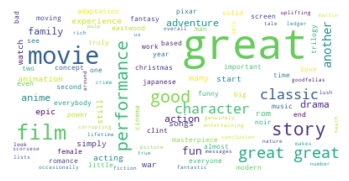

Cluster: 2
Titles
                          Gladiator
                              Alien
                               Coco
                       High and Low
                        Taxi Driver
 Indiana Jones and the Last Crusade
                           Downfall
                             Casino
    Monty Python and the Holy Grail
                There Will Be Blood
                           Rashomon
                Million Dollar Baby
                  On the Waterfront
                          Gone Girl
                        The General
                  The Wages of Fear
                               Jaws
                      Into the Wild


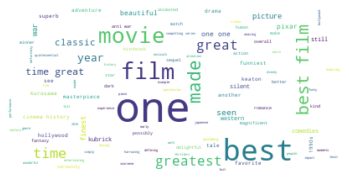

Cluster: 3
Titles
           Pulp Fiction
 Grave of the Fireflies
              Your Name
                 Amélie
                     Up
     To Be or Not to Be


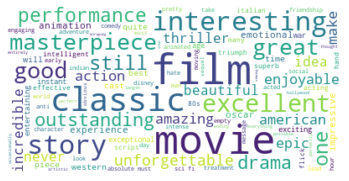

Cluster: 4
Titles
               12 Angry Men
                 Goodfellas
                City of God
                  Star Wars
                The Pianist
         American History X
                   Whiplash
               Modern Times
                      Joker
                    Old Boy
               Citizen Kane
                    Vertigo
                   Scarface
              The Apartment
                       1917
           Some Like It Hot
           The Great Escape
               Blade Runner
              Hacksaw Ridge
              Monsters, Inc
 The Passion of Joan of Arc
               Hotel Rwanda


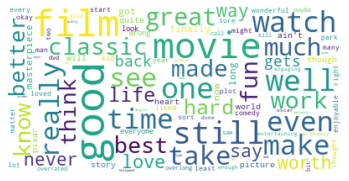

Cluster: 5
Titles
       The Dark Knight
          Forrest Gump
                 Se7en
         Seven Samurai
                Psycho
    The Great Dictator
                Aliens
               Amadeus
 2001: A Space Odyssey
    North by Northwest
                  Heat
       The Sixth Sense
       The Truman Show
               Yojimbo
               Warrior
        Ford v Ferrari
   The Grapes of Wrath
                Gandhi


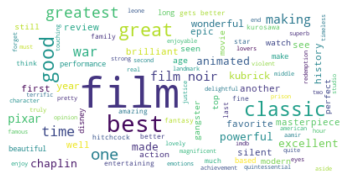

Cluster: 6
Titles
                                        Fight Club
                                     Spirited Away
                                          Parasite
                                      The Prestige
                                  Django Unchained
                                            WALL·E
                                       Sunset Blvd
                            Avengers: Infinity War
                                   American Beauty
                                        The Batman
 Dr Strangelove or: How I Learned to Stop Worry...
                                        Braveheart
                              Inglourious Basterds
                                          The Boat
                       Once Upon a Time in America
        Star Wars: Episode VI - Return of the Jedi
                                    Reservoir Dogs
                                Lawrence of Arabia
                                                 M
             

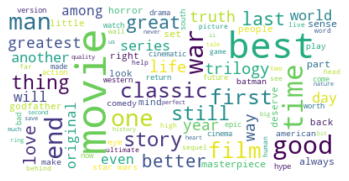

Cluster: 7
Titles
                          The Shawshank Redemption
                                     The Godfather
                            The Godfather: Part II
                                  Schindler's List
 The Lord of the Rings: The Fellowship of the Ring
                    The Good, the Bad and the Ugly
             The Lord of the Rings: The Two Towers
                                        The Matrix
                   One Flew Over the Cuckoo's Nest
                             It's a Wonderful Life
                          The Silence of the Lambs
                               Saving Private Ryan
                                 Life Is Beautiful
                        Terminator 2: Judgment Day
                                Back to the Future
                            Léon: The Professional
                                The Usual Suspects
                                      The Departed
                           Spider-Man: No Way Home
             

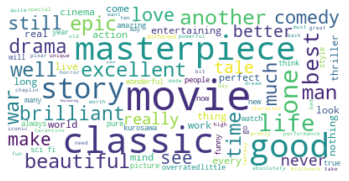

In [31]:
result_k8 = pd.DataFrame({'cluster':labels_k8,'review': sum(list(reviews_dict.values()), [])})

for k in range(0,8):
   s = result_k8[result_k8.cluster == k]
   text = s['review'].str.cat(sep=' ').lower()
   text = ' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   
   print('Titles')
   titles = review_clusters_8[review_clusters_8.cluster == k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

As I scrapped the top 250 movie and 25 reviews each off of IMdb, it seems we have a variety of different movies across a variety of genres. It looks like in our KMeans cluster of 3 our movies are segmented into the following clusters:
* Cluster 0 - Seems to be made up of "moving" pieces
* Cluster 1 - Seems to be action oriented
* Cluster 2 - Seems to be movies regarded as "masterpieces" that are well-known classics.

The clustering of the 8 KMeans seems to be dependent on the word choice used by the 25 reviewers. It's hard to get a sense of like features to describe them and seems to be oriented on some basic words.


3. Explain which of the two clustering results from question 1 is preferable (if one of them is), and why.
I don't think either results are ideal. A lot of the reviews clustering resulted in similar words as shown in the word cloud. I feel that clustering with other features would prove to be more ideal.



Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings. 




I scrapped the top 250 movies on IMdb and took their first page of reviews (i.e. 25 reviews per top movie). Once I collected, I transformed them via a TfidfVectorizer from SKLearn combined with removal of English stop words to transform our raw reviews into a matrix of TF-IDF features. Once I had the TF-IDF features, I used the Elbow Method to determine the ideal K value for KMeans clustering. The initial result showed two elbows, one at 3 and one at 8 for creating the clusters.

For question 2, I created a word cloud to get a general feel for what words were relevant that might have grouped the clusters.

For question 3, I went through the movies and reviews word clouds to get an idea of what was the possible clusters. The smaller k value seemed to be more indicative of the potential of the movie, however, it spreads across a large multitude of genres.

If I were to do this again, I would use a different method and add additional stop words to remove some common words that were relevant across clusters (e.g., movie, film, good, classic, masterpiece) to observe its effect.